# Pylops - Marchenko redatuming

### Author: M.Ravasi

In this notebook we consider to extensions of the Marchenko inversion:

- in the presence of missing sources
- in the presence of band-limited data (with known or unknown wavelet)

In [1]:
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

## Inputs

Input parameters 

In [2]:
inputfile = '../data/marchenko/input.npz' # choose file in testdata folder of repo

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 20         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [3]:
inputdata = np.load(inputfile)

Read and visualize geometry

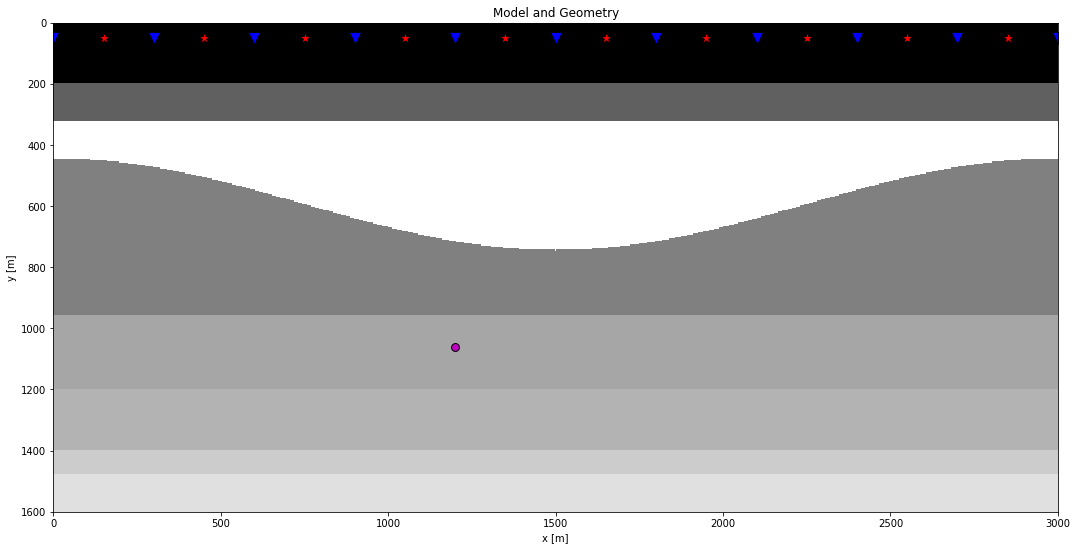

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [5]:
# time axis
t = inputdata['t']
t2 = np.concatenate([-t[::-1], t[1:]])
ot, dt, nt, nt2 = t[0], t[1]-t[0], len(t), len(t2)

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[s, r, f] assume particle velocity receiver and integrate over them (via reciprocity)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

Read subsurface fields and wavelet to apply to subsurface fields

In [6]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

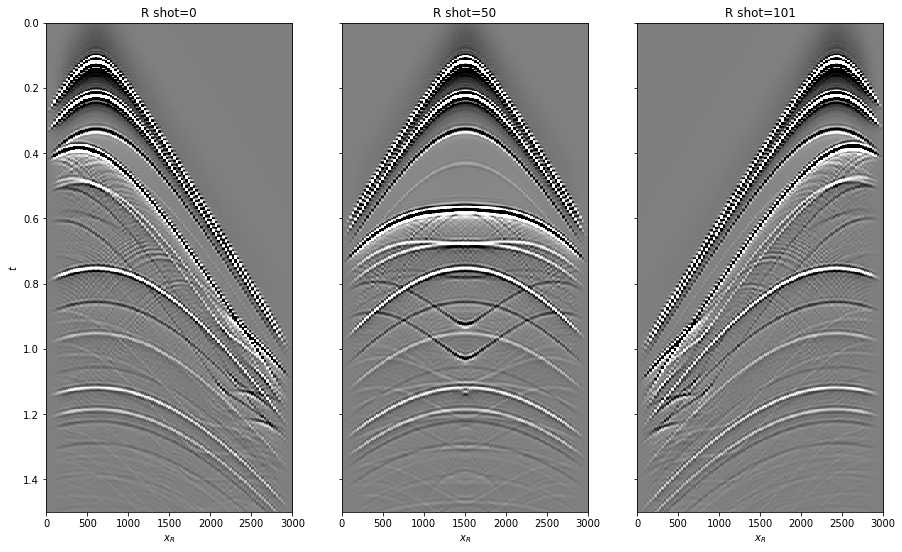

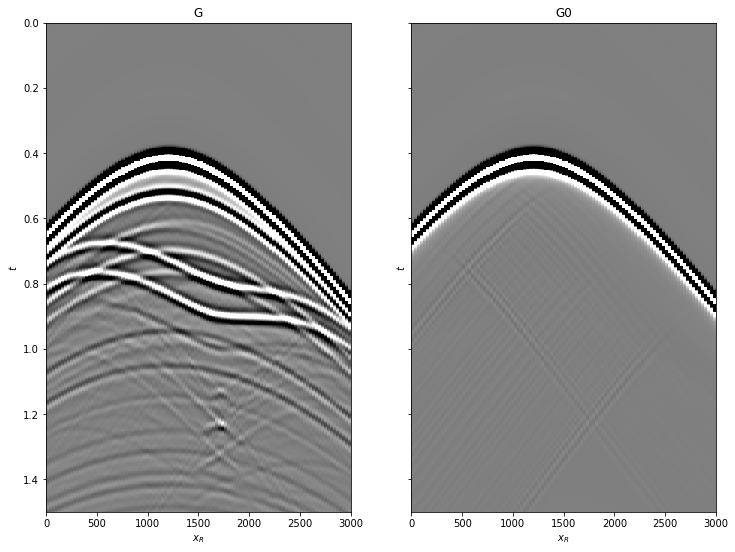

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

## Marchenko preparation

Create window

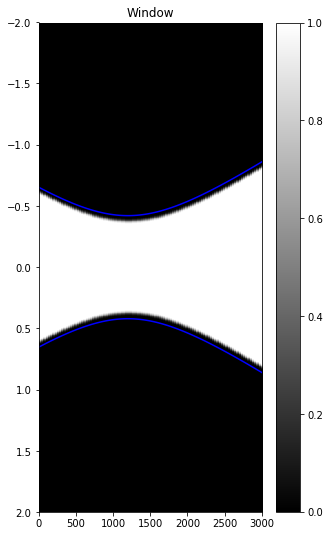

In [8]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.plot(r[0], directVS,'b'),ax.plot(r[0], -directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

Create analytical direct wave

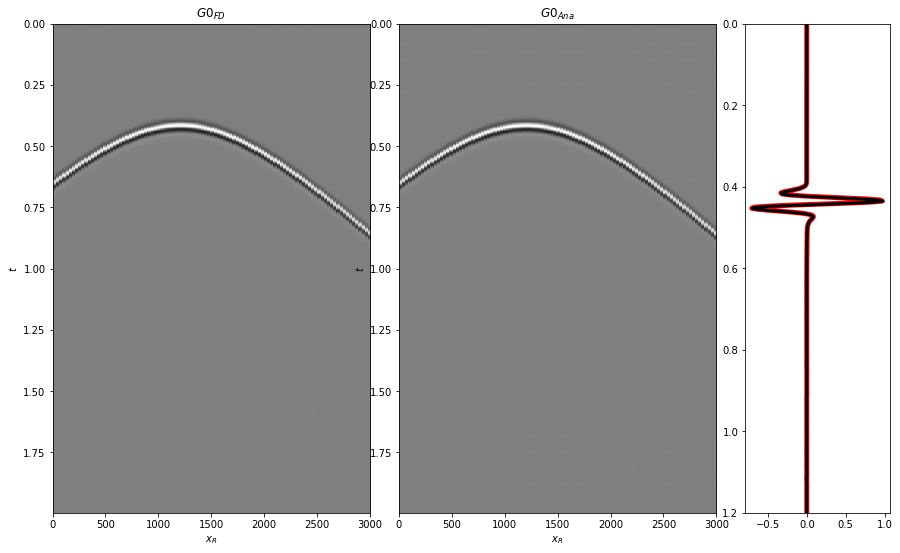

In [9]:
G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11)

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Marchenko with missing sources

Let's consider the case of missing sources. We will restrict $R$ and at the same time replace the Identity operator with a Restriction operator along the main diagonal of the Marchenko operator.

To be able to deal with missing sources (and gaps in the retrieved focusing functions) we will use a sliding linear Radon sparsity transform and L1 solver FISTA.

In [10]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((ns, nr, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, s, r]

# subsampling
perc_subsampling=0.6
nsava=int(np.round(ns*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ns))[:nsava])
Rtwosided_fft = Rtwosided_fft[:, iava]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, dtype='complex64')
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, conj=True, dtype='complex64')
Rollop = Roll((2*nt-1) * nsava,
              dims=(2*nt-1, nsava),
              dir=0, shift=-1)
Restrop = Restriction(ns*(2*nt-1), iava, dims=(2*nt-1, ns), dir=1, dtype='float64')
Wsop = Diagonal(w[iava].T.flatten())
Wrop = Diagonal(w.T.flatten())

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

Create Marchenko operator

In [11]:
Mop = VStack([HStack([Restrop, -1*Wsop*Rop]),
              HStack([-1*Wsop*Rollop*R1op, Restrop])])*BlockDiag([Wrop, Wrop])
Gop = VStack([HStack([Restrop, -1*Rop]),
              HStack([-1*Rollop*R1op, Restrop])])

dottest(Gop, 2*nsava*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*nsava*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=-49.868533 - u^T(Op^Tv)=-49.868533
Dot test passed, v^T(Opu)=-24.119895 - u^T(Op^Tv)=-24.119895


Run standard redatuming as benchmark

In [12]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), nsava).T

Create data, adjoint and inverse focusing functions

In [13]:
d = Wsop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(2*nt-1, nsava), np.zeros((2*nt-1, nsava))))

f1_adj = Mop.H*d.flatten()
f1_inv = lsqr(Mop, d.flatten(), iter_lim=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*nt2, nr)
f1_inv = f1_inv.reshape(2*nt2, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   195078 rows  and   322998 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.326e+07  2.326e+07    1.0e+00  4.4e-08
     1  0.00000e+00   7.639e+06  7.639e+06    3.3e-01  1.0e+00   1.1e+00  1.0e+00
     2  0.00000e+00   3.525e+06  3.525e+06    1.5e-01  4.9e-01   1.7e+00  2.1e+00
     3  0.00000e+00   2.131e+06  2.131e+06    9.2e-02  4.3e-01   2.0e+00  3.3e+00
     4  0.00000e+00   1.117e+06  1.117e+06    4.8e-02  3.7e-01   2.4e+00  4.8e+00
     5  0.00000e+00   7.084e+05  7.084e+05    3.0e-02  2.8e-01   2.7e+00  6.1e+00
     6  0.00000e+00   4.663e+05  4.663e+05    2.0e-02  2.9e-01   2.9e+00  7.5e+00
     7  0.00000e+00   3.053e+05  3.053e+05    1.3e-02  2.4e-01   3.2e+00  9.1e+00
     8  0.00000e+00   2.266e

Add initial guess to estimated focusing functions

In [14]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))

f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, nr)),
                                      fd_plus))

Estimate Green's functions

In [15]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nsava)
g_inv = g_inv.reshape(2*(2*nt-1), nsava)

Extract up and down focusing and Green's functions from model vectors

In [16]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

Visualization

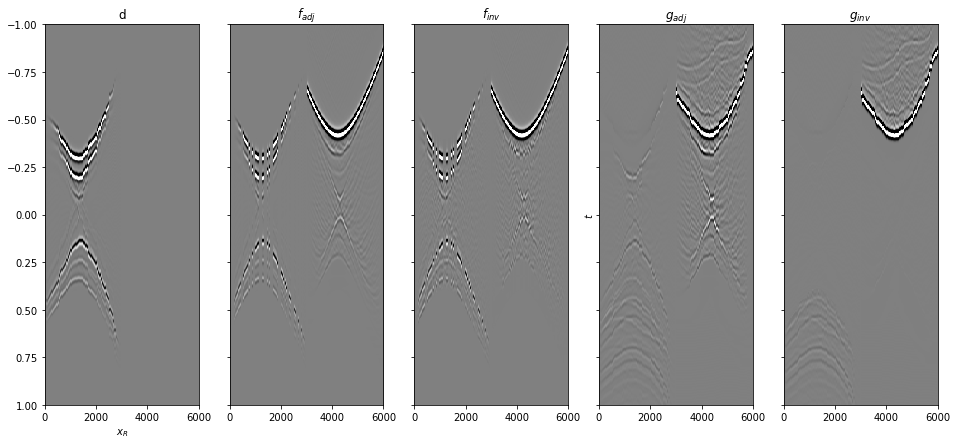

In [17]:
# Need to recreate combined data as new implementation stacks over time instead of space
d_plot = np.concatenate((d[:(2*nt-1)], d[(2*nt-1):]), axis=1).T
f1_adj_tot_plot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot_plot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj_plot = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv_plot = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_adj_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_adj_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_inv_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

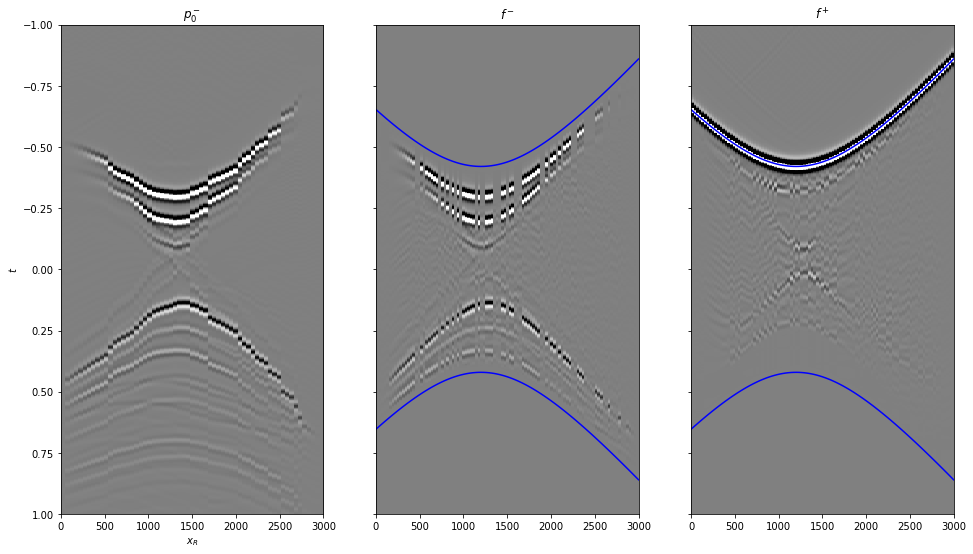

In [18]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

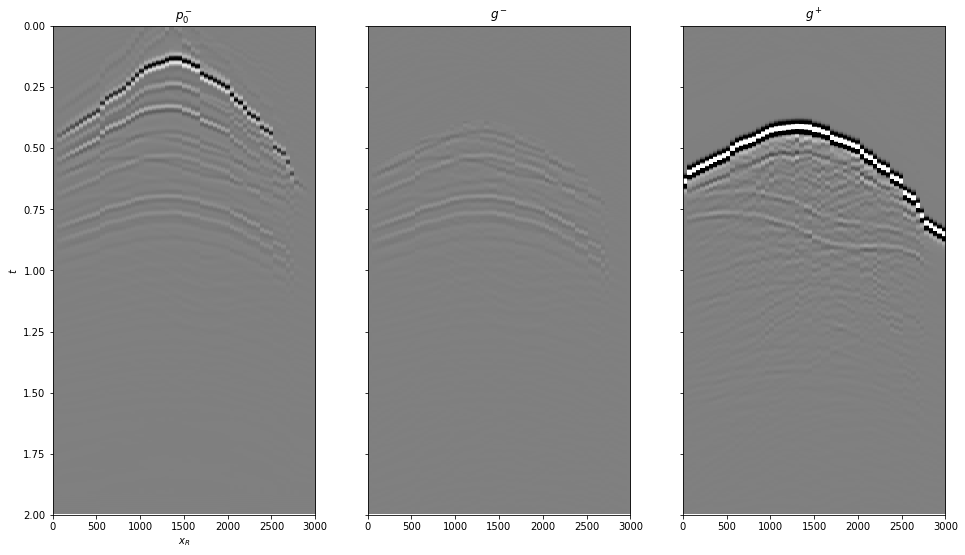

In [19]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(g_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

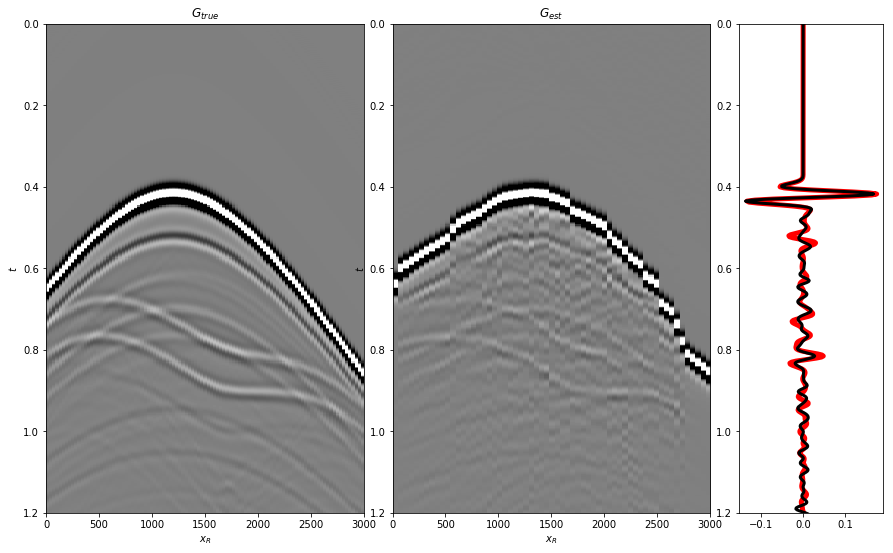

In [20]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(t**2*Gsub[:, iava][:, nr//4]/Gsub.max(), t, 'r', lw=5)
ax3.plot(t**2*g_inv_tot[nr//4, nt-1:]/g_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

### Radon reconstruction

We try now to express the focusing functions as local linear events in an attempt to fill the gaps

In [21]:
nwin=25
nwins=6
nover=10
npx=101
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
dimsd = (nr, nt2) 
dimss = (nwins*npx, dimsd[1])

# tranpose operator
Top = Transpose((nt2, nr), axes=(1, 0), dtype=np.float64)

# sliding window radon with overlap
RadOp = Radon2D(t2, np.linspace(-dr*nwin//2, dr*nwin//2, nwin), px, centeredh=True,
                kind='linear', engine='numba')
Slidop = Sliding2D(RadOp, dimss, dimsd, nwin, nover, tapertype='cosine', design=True)
dottest(Slidop, np.prod(dimsd), np.prod(dimss), verb=True);

Dot test passed, v^T(Opu)=-1890.509363 - u^T(Op^Tv)=-1890.509363


(-0.5, 605.5, 1598.5, -0.5)

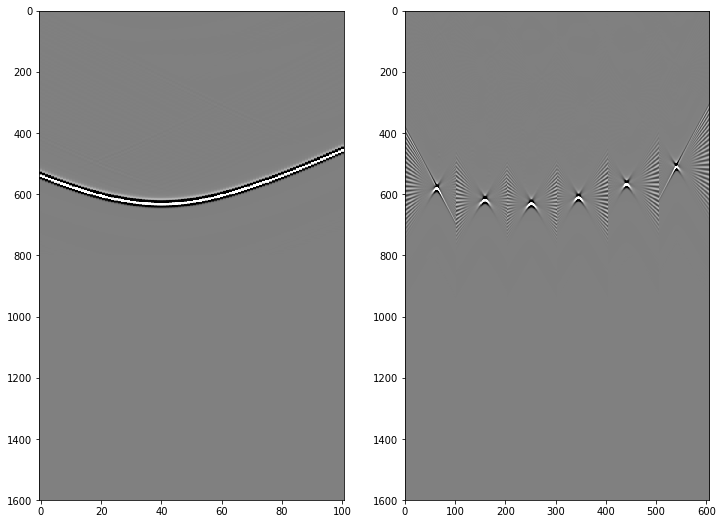

In [22]:
fd_plus_radon = Slidop.H * fd_plus.T.flatten()
fd_plus_radon = fd_plus_radon.reshape(npx*nwins, nt2)

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(fd_plus, cmap='gray', vmin=-5e5, vmax=5e5)
axs[0].axis('tight')
axs[1].imshow(fd_plus_radon.T, cmap='gray', vmin=-5e6, vmax=5e6)
axs[1].axis('tight')

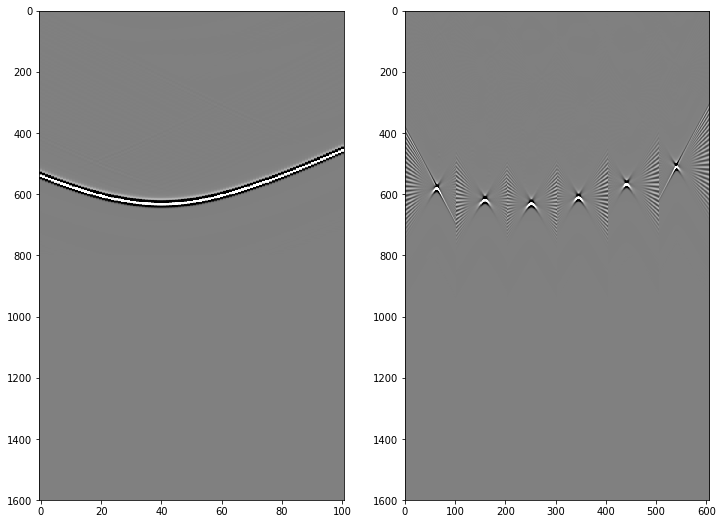

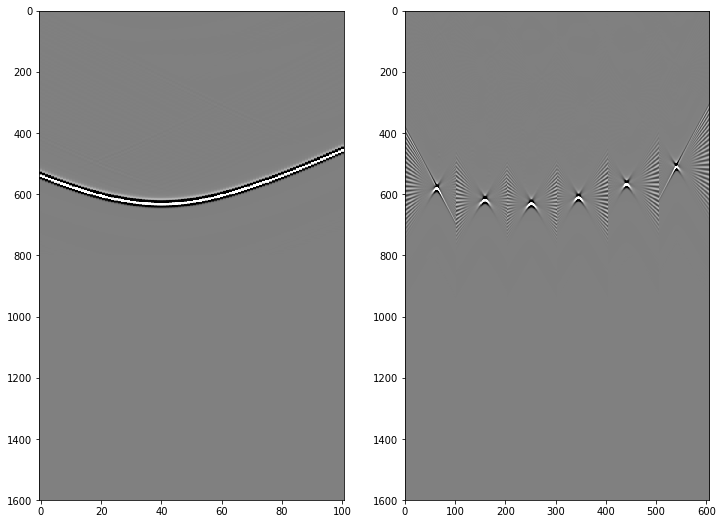

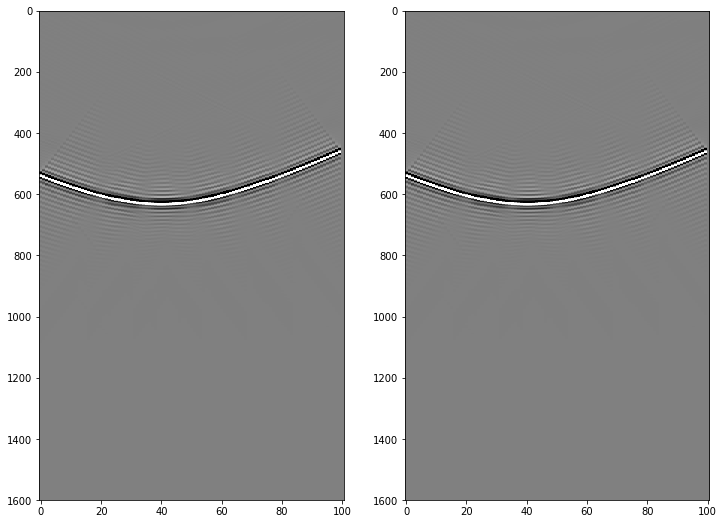

In [23]:
Sparseop = BlockDiag([Top.H*Slidop, Top.H*Slidop])

fd_plus1 = np.concatenate([fd_plus, fd_plus])
fd_plus1_radon = Sparseop.H*fd_plus1.flatten()
fd_plus2_radon = Sparseop*fd_plus1_radon

fd_plus1_radon = fd_plus1_radon.reshape(2*npx*nwins, nt2)
fd_plus2_radon = fd_plus2_radon.reshape(2*nt2, nr)

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(fd_plus1[:nt2], cmap='gray', vmin=-5e5, vmax=5e5)
axs[0].axis('tight')
axs[1].imshow(fd_plus1_radon[:npx*nwins].T, cmap='gray', vmin=-5e6, vmax=5e6)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(fd_plus1[nt2:], cmap='gray', vmin=-5e5, vmax=5e5)
axs[0].axis('tight')
axs[1].imshow(fd_plus1_radon[npx*nwins:].T, cmap='gray', vmin=-5e6, vmax=5e6)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(fd_plus2_radon[nt2:], cmap='gray', vmin=-5e7, vmax=5e7)
axs[0].axis('tight')
axs[1].imshow(fd_plus2_radon[:nt2], cmap='gray', vmin=-5e7, vmax=5e7)
axs[1].axis('tight');

In [24]:
Mop_radon = Mop * Sparseop

dottest(Mop_radon, 2*nsava*(2*nt-1), 2*np.prod(dimss), verb=True);

Dot test passed, v^T(Opu)=-1035.404870 - u^T(Op^Tv)=-1035.404870


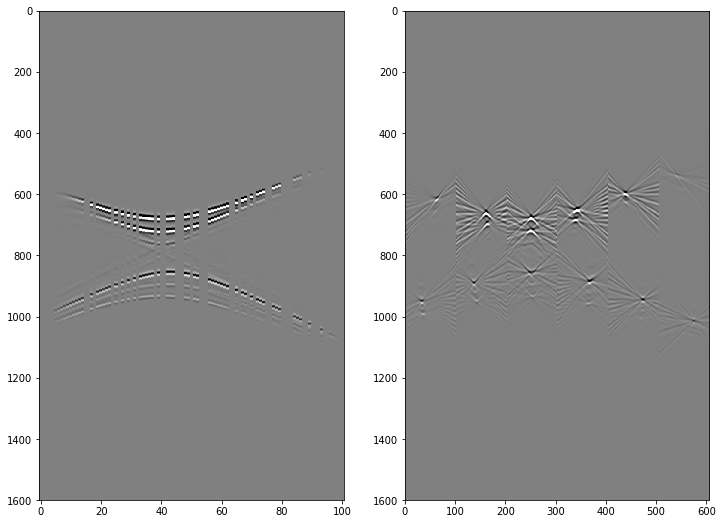

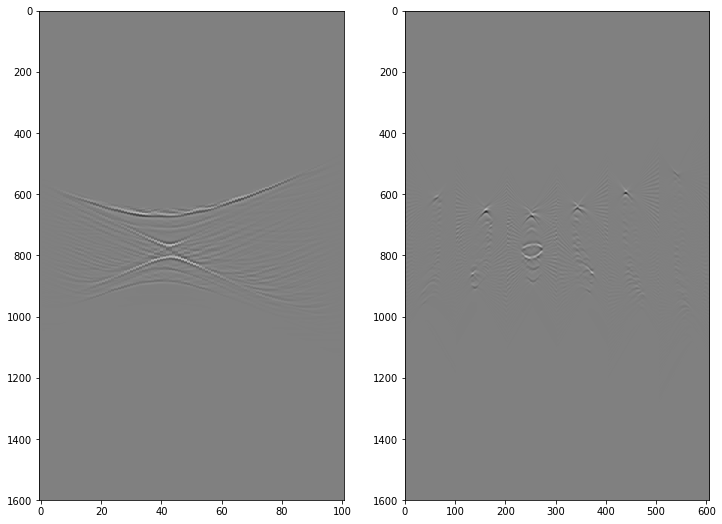

In [25]:
f1_adj_radon = Mop_radon.H*d.flatten()
f1_adj_radon = f1_adj_radon.reshape(2*npx*nwins, nt2)

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(f1_adj[:nt2], cmap='gray', vmin=-5e5, vmax=5e5)
axs[0].axis('tight')
axs[1].imshow(f1_adj_radon[:npx*nwins].T, cmap='gray', vmin=-3e6, vmax=3e6)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(f1_adj[nt2:], cmap='gray', vmin=-5e5, vmax=5e5)
axs[0].axis('tight')
axs[1].imshow(f1_adj_radon[npx*nwins:].T, cmap='gray', vmin=-3e6, vmax=3e6)
axs[1].axis('tight');

In [26]:
#f1_radon_inv = lsqr(Mop_radon, d.flatten(), iter_lim=n_iter*2, show=True)[0]
f1_radon_inv = FISTA(Mop_radon, d.flatten(), niter=n_iter*5, eps=2e5, 
                     alpha = 1.05e-3, #eigsiter=4, eigstol=1e-3, 
                     returninfo=False, show=True)[0]
f1_radon_inv = Sparseop * f1_radon_inv

f1_radon_inv = f1_radon_inv.reshape(2*nt2, nr)

FISTA optimization
-----------------------------------------------------------
The Operator Op has 195078 rows and 1937988 cols
eps = 2.000000e+05	tol = 1.000000e-10	niter = 100
alpha = 1.050000e-03	thresh = 1.050000e+02
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   2.306e+14   2.384e+14   1.994e+05
     2   0.00000e+00   1.981e+14   2.127e+14   1.792e+05
     3   0.00000e+00   1.643e+14   1.867e+14   2.072e+05
     4   0.00000e+00   1.322e+14   1.627e+14   2.234e+05
     5   0.00000e+00   1.038e+14   1.423e+14   2.295e+05
     6   0.00000e+00   7.993e+13   1.262e+14   2.271e+05
     7   0.00000e+00   6.088e+13   1.143e+14   2.182e+05
     8   0.00000e+00   4.622e+13   1.059e+14   2.046e+05
     9   0.00000e+00   3.528e+13   1.003e+14   1.883e+05
    10   0.00000e+00   2.729e+13   9.670e+13   1.708e+05
    11   0.00000e+00   2.154e+13   9.440e+13   1.535e+05
    21   0.00000e+00   7.519e+12   

In [27]:
f1_radon_inv_tot = f1_radon_inv + np.concatenate((np.zeros((nt2, nr)), fd_plus))

g_radon_inv = Gop*f1_radon_inv_tot.flatten()
g_radon_inv = g_radon_inv.reshape(2*(2*nt-1), nsava)

f1_radon_inv_minus, f1_radon_inv_plus =  f1_radon_inv_tot[:(2*nt-1)].T, f1_radon_inv_tot[(2*nt-1):].T
g_radon_inv_minus, g_radon_inv_plus =  -g_radon_inv[:(2*nt-1)].T, np.fliplr(g_radon_inv[(2*nt-1):].T)

g_radon_inv_tot = g_radon_inv_minus + g_radon_inv_plus

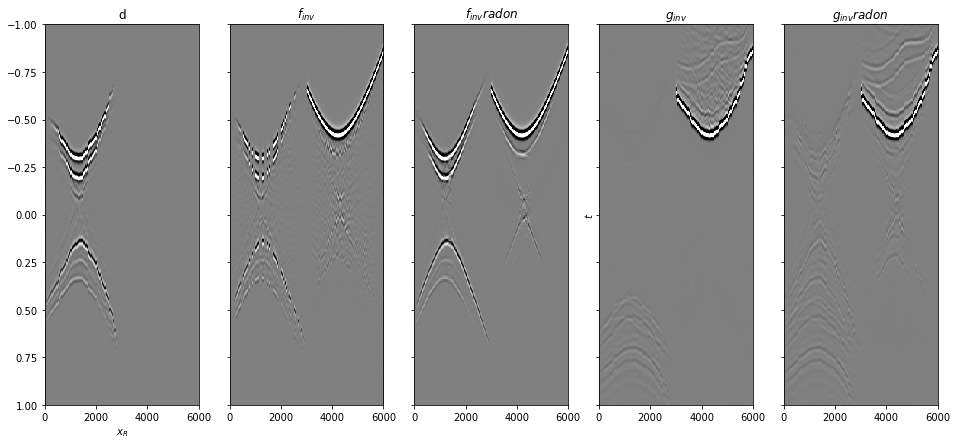

In [28]:
# Need to recreate combined data as new implementation stacks over time instead of space
f1_radon_inv_tot_plot = np.concatenate((f1_radon_inv_tot[:(2*nt-1)], f1_radon_inv_tot[(2*nt-1):]), axis=1).T
g_radon_inv_plot = np.concatenate((g_radon_inv[:(2*nt-1)], g_radon_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_inv_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_radon_inv_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv} radon$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_inv_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_radon_inv_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv} radon$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

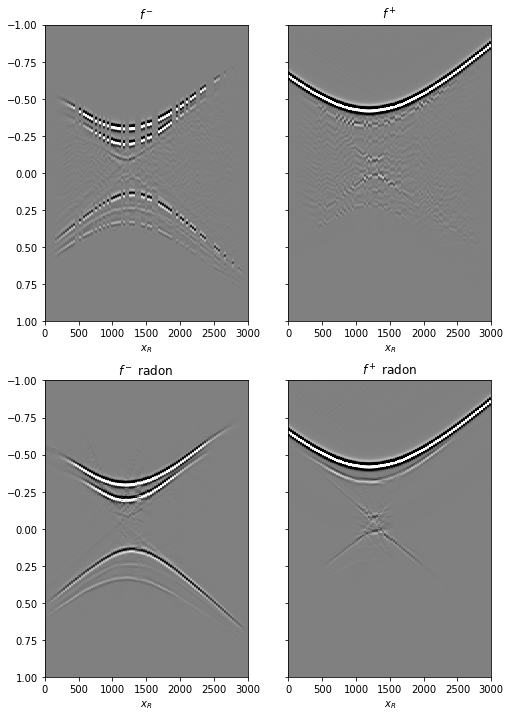

In [29]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 12))
axs[0][0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0][0].set_title(r'$f^-$'), axs[0][0].set_xlabel(r'$x_R$')
axs[0][0].axis('tight')
axs[0][0].set_ylim(1, -1);
axs[0][1].imshow(f1_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0][1].set_title(r'$f^+$'), axs[0][1].set_xlabel(r'$x_R$')
axs[0][1].axis('tight')
axs[0][1].set_ylim(1, -1);
axs[1][0].imshow(f1_radon_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1][0].set_title(r'$f^-$ radon'), axs[1][0].set_xlabel(r'$x_R$')
axs[1][0].axis('tight')
axs[1][0].set_ylim(1, -1);
axs[1][1].imshow(f1_radon_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1][1].set_title(r'$f^+$ radon'), axs[1][1].set_xlabel(r'$x_R$')
axs[1][1].axis('tight')
axs[1][1].set_ylim(1, -1);

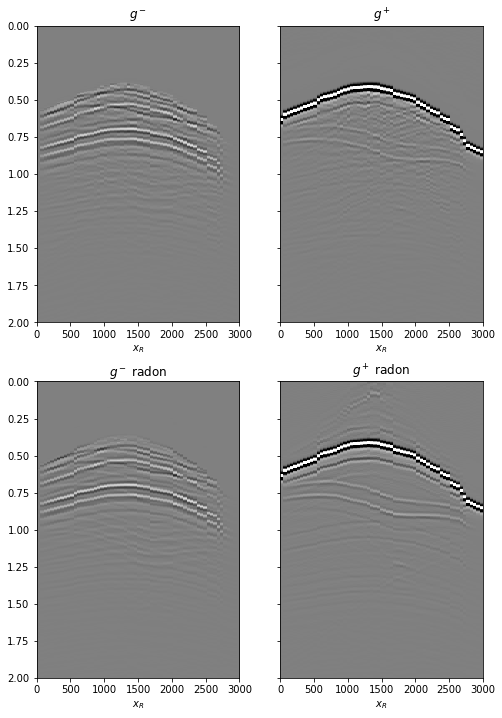

In [30]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 12))
axs[0][0].imshow((1-w[iava].T)*g_inv_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, 
                 extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0][0].set_title(r'$g^-$'), axs[0][0].set_xlabel(r'$x_R$')
axs[0][0].axis('tight')
axs[0][0].set_ylim(2, 0);
axs[0][1].imshow(g_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0][1].set_title(r'$g^+$'), axs[0][1].set_xlabel(r'$x_R$')
axs[0][1].axis('tight')
axs[0][1].set_ylim(2, 0);
axs[1][0].imshow((1-w[iava].T)*g_radon_inv_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, 
                 extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1][0].set_title(r'$g^-$ radon'), axs[1][0].set_xlabel(r'$x_R$')
axs[1][0].axis('tight')
axs[1][0].set_ylim(2, 0);
axs[1][1].imshow(g_radon_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1][1].set_title(r'$g^+$ radon'), axs[1][1].set_xlabel(r'$x_R$')
axs[1][1].axis('tight')
axs[1][1].set_ylim(2, 0);

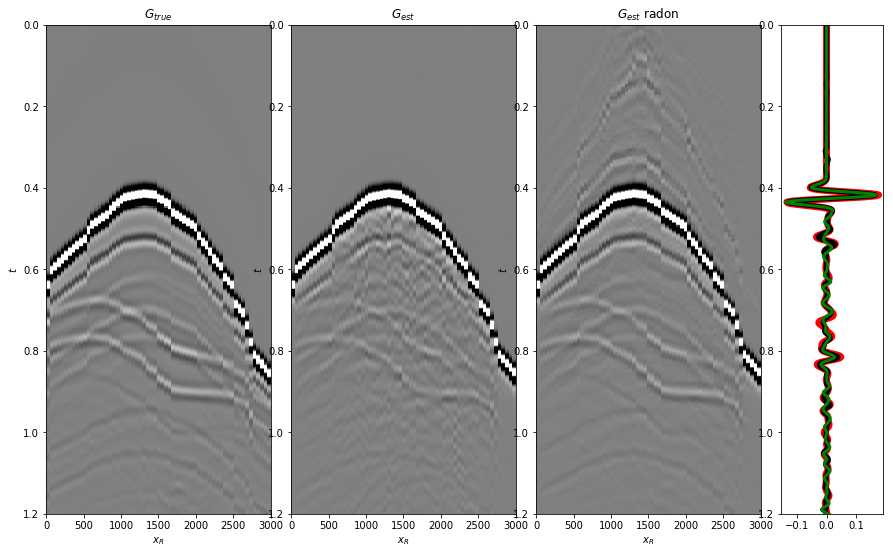

In [31]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 7), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 7), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 7), (0, 6))

ax1.imshow(Gsub[:, iava], cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)
ax3.imshow(g_radon_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est}$ radon'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(1.2, 0)

ax4.plot(t**2*Gsub[:, iava][:, nr//4]/Gsub.max(), t, 'r', lw=7)
ax4.plot(t**2*g_inv_tot[nr//4, nt-1:]/g_inv_tot.max(), t, 'k', lw=5)
ax4.plot(t**2*g_radon_inv_tot[nr//4, nt-1:]/g_radon_inv_tot.max(), t, 'g', lw=3)
ax4.set_ylim(1.2, 0);

## Marchenko with band-limited data

We consider now the case of band-limitied reflectivity (i.e., convolved with wavelet). We modify the Marchenko equations to account for it and we also use a broad-band (i.e., spiky) initial focusing function.

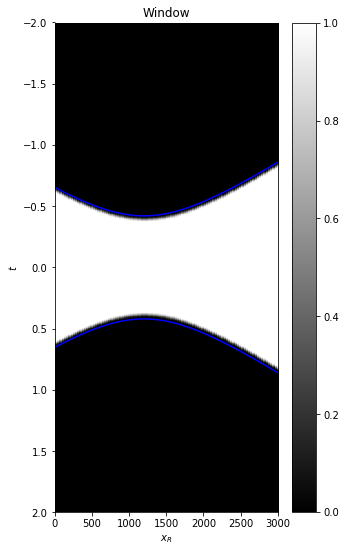

In [33]:
# direct arrival window - traveltime
toffw = toff - 0.015
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toffw

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.plot(r[0], directVS,'b'),ax.plot(r[0], -directVS,'b')
ax.set_title('Window'), ax.set_xlabel(r'$x_R$'), ax.set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

In [34]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]

In [35]:
# Convolve R with wavelet
Rwav = np.apply_along_axis(convolve, 2, R, wav, mode='full')
Rwav = Rwav[:,:,wav_c:]

# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((ns, nr, nt-1)), Rwav), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, s, r]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, dtype='complex64')
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, conj=True, dtype='complex64')
Rollop = Roll((2*nt-1) * ns,
              dims=(2*nt-1, ns),
              dir=0, shift=-1)
Wavop = Convolve1D(ns*nt2, wav, wav_c, dims=(nt2, ns), dir=0, dtype='float64')
Wop = Diagonal(w.T.flatten())

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

In [36]:
Mop = VStack([HStack([Wavop, -1*Wop*Rop]),
              HStack([-1*Wop*Rollop*R1op, Wavop])])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Wavop, -1*Rop]),
              HStack([-1*Rollop*R1op, Wavop])])

dottest(Gop, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=959.817863 - u^T(Op^Tv)=959.817863
Dot test passed, v^T(Opu)=314.993113 - u^T(Op^Tv)=314.993113


In [37]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape(nt2, ns).T

d = Wop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(nt2, ns), np.zeros((nt2, ns))))

f1_adj = Mop.H*d.flatten()
f1_inv = lsqr(Mop, d.flatten(), iter_lim=n_iter*2, show=True)[0]

f1_adj = f1_adj.reshape(2*nt2, nr)
f1_inv = f1_inv.reshape(2*nt2, nr)

f1_adj_tot = f1_adj + np.concatenate((np.zeros((nt2, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))

f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, nr)),
                                      fd_plus))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   322998 rows  and   322998 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       40
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.987e+07  2.987e+07    1.0e+00  2.4e-07
     1  0.00000e+00   1.710e+07  1.710e+07    5.7e-01  7.9e-01   8.7e+00  1.0e+00
     2  0.00000e+00   1.185e+07  1.185e+07    4.0e-01  3.8e-01   1.4e+01  2.3e+00
     3  0.00000e+00   9.266e+06  9.266e+06    3.1e-01  2.9e-01   1.7e+01  3.7e+00
     4  0.00000e+00   7.325e+06  7.325e+06    2.5e-01  2.2e-01   2.0e+01  5.4e+00
     5  0.00000e+00   6.141e+06  6.141e+06    2.1e-01  1.8e-01   2.2e+01  7.1e+00
     6  0.00000e+00   5.148e+06  5.148e+06    1.7e-01  1.8e-01   2.4e+01  9.0e+00
     7  0.00000e+00   4.406e+06  4.406e+06    1.5e-01  1.3e-01   2.6e+01  1.1e+01
     8  0.00000e+00   3.961e

In [38]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*nt2, ns)
g_inv = g_inv.reshape(2*nt2, ns)

f1_adj_minus, f1_adj_plus =  f1_adj_tot[:nt2].T, f1_adj_tot[nt2:].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:nt2].T, f1_inv_tot[nt2:].T

g_adj_minus, g_adj_plus =  -g_adj[:nt2].T, np.fliplr(g_adj[nt2:].T)
g_inv_minus, g_inv_plus =  -g_inv[:nt2].T, np.fliplr(g_inv[nt2:].T)

g_inv_tot = g_inv_minus + g_inv_plus

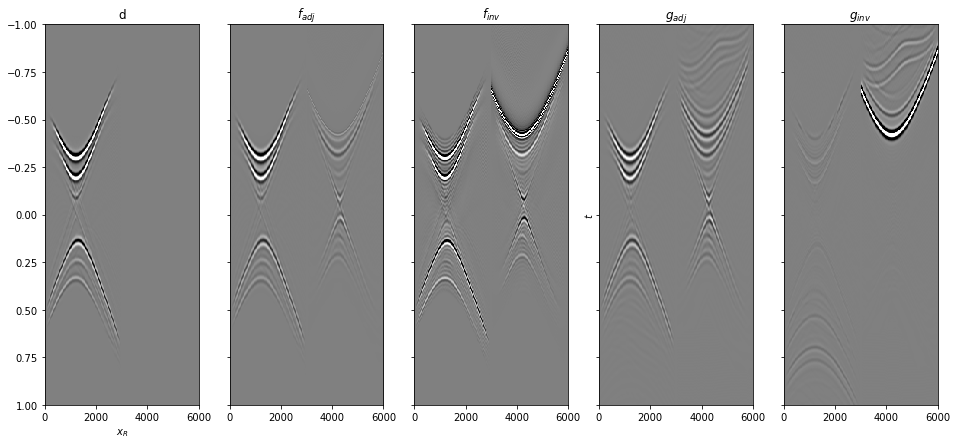

In [39]:
# Need to recreate combined data as new implementation stacks over time instead of space
d_plot = np.concatenate((d[:(2*nt-1)], d[(2*nt-1):]), axis=1).T
f1_adj_tot_plot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot_plot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj_plot = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv_plot = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_adj_tot_plot.T, cmap='gray', vmin=-5e6, vmax=5e6, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_tot_plot.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_adj_plot.T, cmap='gray', vmin=-5e7, vmax=5e7, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_inv_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

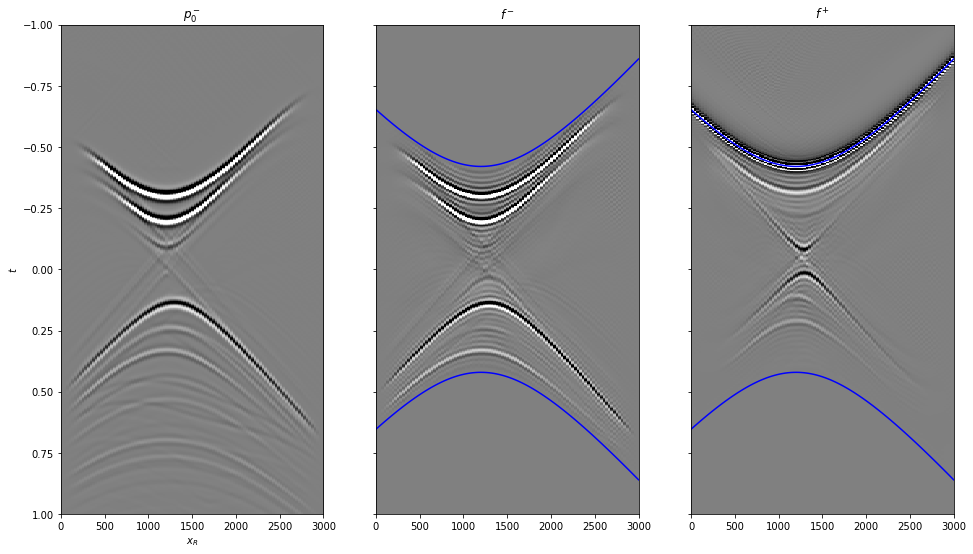

In [40]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

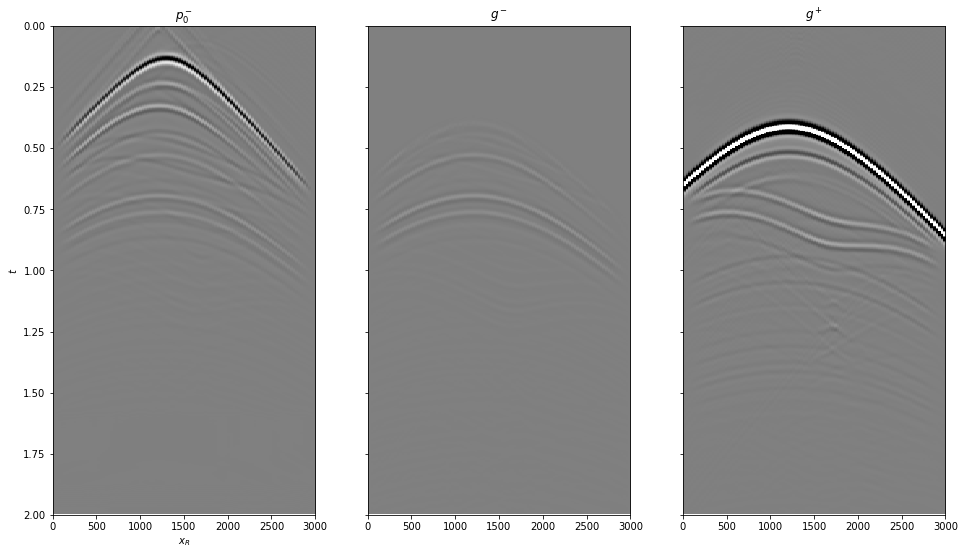

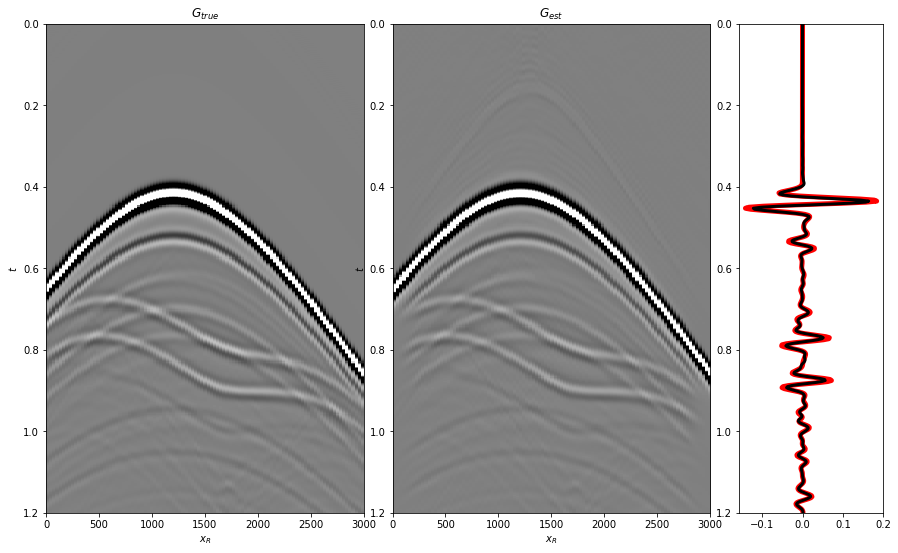

In [41]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow((1-w.T)*g_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(t**2*Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(t**2*g_inv_tot[nr//2, nt-1:]/g_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

Finally we try using a sparse solver

In [92]:
#f1_sparse_inv = FISTA(Mop, d.flatten(), niter=n_iter*2, eps=1e5, 
#                      alpha=4.850838e-3, #eigsiter=4, eigstol=1e-3, 
#                      returninfo=False, show=True)[0]
f1_sparse_inv = SPGL1(Mop, d.flatten(), tau=3e8, iter_lim=30, verbosity=2)[0]
f1_sparse_inv = f1_sparse_inv.reshape(2*nt2, nr)

f1_sparse_inv_tot = f1_sparse_inv + np.concatenate((np.zeros((2*nt-1, nr)), fd_plus))


SPGL1
No. rows              :   322998     
No. columns           :   322998

Initial tau           : 3.00e+08     
Two-norm of b         : 2.99e+07

Optimality tol        : 1.00e-04     
Target one-norm of x  : 3.00e+08

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       30

iterr      Objective   Relative Gap      gnorm   stepg   nnz_x   nnz_g

    0  2.9874520e+07  5.1162277e+00   7.61e+06     0.0       0       0       
    1  2.9873820e+07  5.1163020e+00   7.61e+06     0.0   60503       1       
    2  1.7100467e+07  6.9488241e+00   3.39e+06     0.0   86002       0       
    3  1.4269648e+07  8.4269782e+00   3.16e+06     0.0   86065       0       
    4  1.1085345e+07  9.0438995e+00   2.01e+06     0.0   86100       0       
    5  9.5540804e+06  5.2159292e+00   1.06e+06     0.0   63278       1       
    6  8.9140675e+06  4.6879649e+00   8.61e+05     0.0   38555       1       
    7  7.6325788e+06  4.9472319e+00   6.85e+05     0.0   23961       1       
    8  8.

In [93]:
g_sparse_inv = Gop*f1_sparse_inv_tot.flatten()
g_sparse_inv = g_sparse_inv.reshape(2*nt2, ns)

f1_sparse_inv_minus, f1_sparse_inv_plus =  f1_sparse_inv_tot[:nt2].T, f1_sparse_inv_tot[nt2:].T
g_sparse_inv_minus, g_sparse_inv_plus =  -g_sparse_inv[:nt2].T, np.fliplr(g_sparse_inv[nt2:].T)
g_sparse_inv_tot = g_sparse_inv_minus + g_sparse_inv_plus

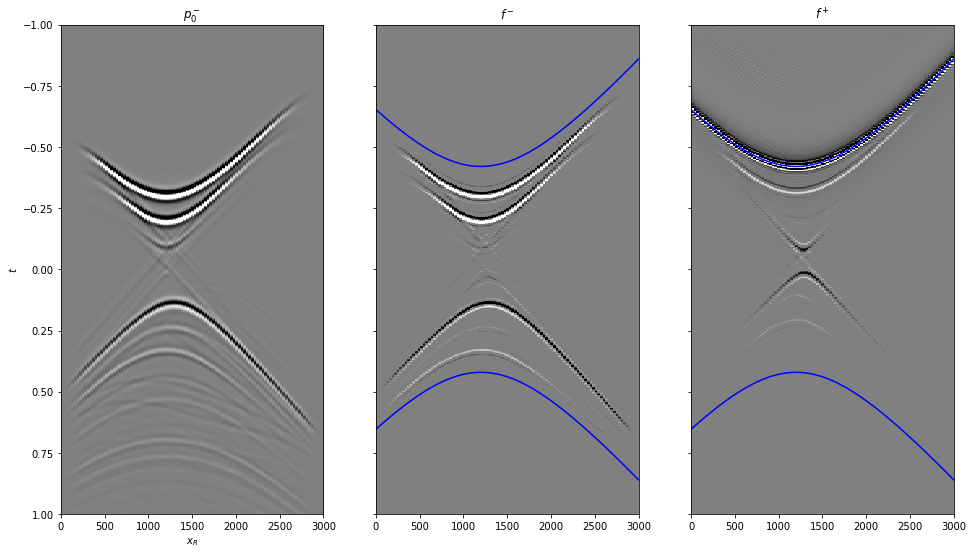

In [94]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_sparse_inv_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_sparse_inv_plus.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

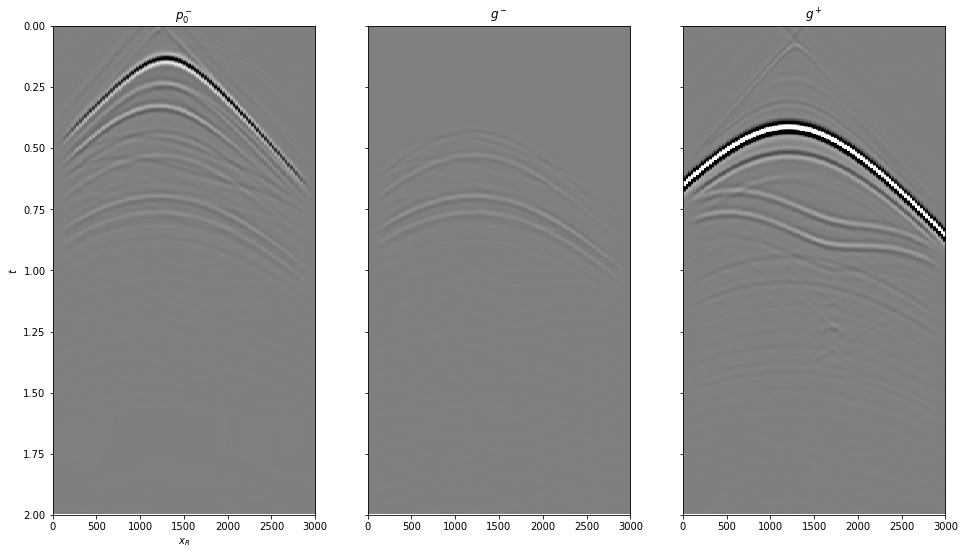

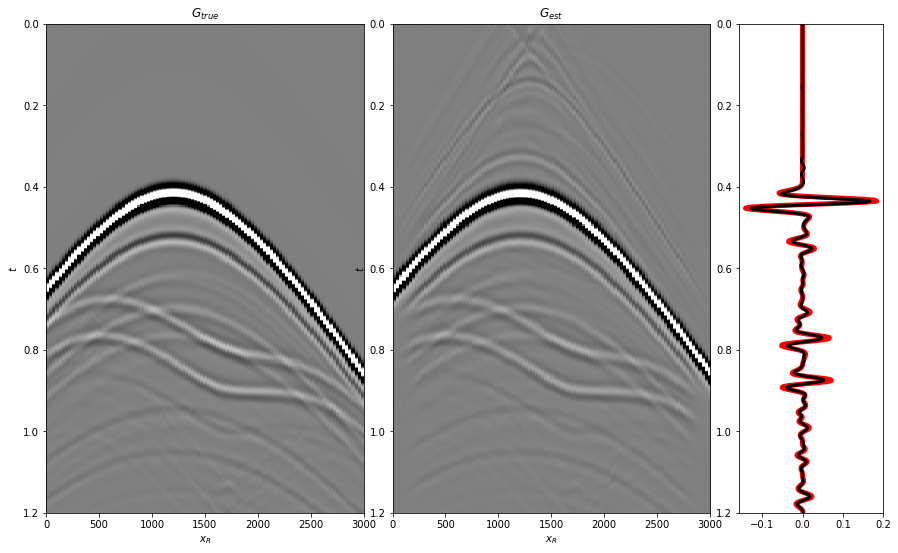

In [95]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow((1-w.T)*g_sparse_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_sparse_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_sparse_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(t**2*Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(t**2*g_sparse_inv_tot[nr//2, nt-1:]/g_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);